In [1]:
import pandas as pd
import numpy as np
import re 
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.offsetbox import AnchoredText
import plotly.graph_objects as go 
import plotly.express as px
from imblearn.over_sampling import RandomOverSampler
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
import warnings
from numpy import mean,sqrt,square 
from scipy.stats import kurtosis,skew 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.cluster import KMeans
from scipy.fftpack import fft, fftfreq
from sklearn.model_selection import train_test_split 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# dfs risk

In [2]:
df_risk=pd.read_parquet("DF_Factor_Riesgo_LS1_Final.parquet").dropna().rename(columns={"mean_arcillas_3":"threshold_arcilla","mean_avg_finos_3_(t-1)":"threshold_finos","probability_atollo":"probability"})
for i in df_risk.threshold_arcilla.unique():
    df_risk["probability"][df_risk["threshold_arcilla"]==i]=df_risk["probability"][df_risk["threshold_arcilla"]==i].rolling(3).mean()
    #print(i)
df_risk=df_risk[df_risk['threshold_finos']<=82]
df_risk.dropna(inplace=True)
df_risk=df_risk[(df_risk["threshold_arcilla"].isin([0.27,0.28,0.29,0.3,0.31,0.34,0.38]))]
df_risk

,threshold_arcilla,threshold_finos,probability
index,,,
4,0.27,74,0.117000
5,0.27,75,0.117000
6,0.27,76,0.117333
7,0.27,77,0.117667
8,0.27,78,0.118000
...,...,...,...
8,0.38,78,0.203333
9,0.38,79,0.217667
10,0.38,80,0.235667


In [3]:
fig = go.Figure()
for i in df_risk.threshold_arcilla.unique():
    # Create traces

    #fig.add_trace(go.Scatter(x=dic_data[0]['threshold_finos'], y=dic_data[0]['probability'],mode='lines',name='Arcillas corte 0'))
    #fig.add_trace(go.Scatter(x=dic_data[0.25]['threshold_finos'], y=dic_data[0.25]['probability'],mode='lines',name='Arcillas corte 0.25'))
    fig.add_trace(go.Scatter(x=df_risk.query(f"threshold_arcilla=={i}")['threshold_finos'], y=df_risk.query(f"threshold_arcilla=={i}")['probability'],mode='lines',name=f'Arcillas corte {i}'))

fig.update_layout(height=500,width=1200,title_text="Índice de riesgo vs criterio de corte finos")
fig.update_xaxes(title_text="Threshold finos" )
fig.update_yaxes(title_text="% de atollos detectados respecto del grupo filtrado")
fig.show()

In [4]:
median_probability=df_risk["probability"].quantile(0.5)
median_probability

0.11733333333333333

In [5]:
max_probability=df_risk["probability"].quantile(1)
max_probability

0.291

-------------------

In [6]:
df=pd.read_parquet('DF_Total_recomendaciones_LS1.parquet')
df=df[df["mean_avg_fresh_feed_tonnage_3_(t-1)"]>4990]
for i in df.columns:
    df=df[df[i]>=0]
df2=df.copy()

# variable dummie para riesgo arcilla
df2['riesgo_arcilla']=df2.mean_arcillas_3.apply(lambda x : 1 if x> 0.29 else 0 )

In [7]:
df2.shape

(1556, 18)

In [8]:
df2["mean_avg_rpm_3_(t-1)"].describe()

count    1556.000000
mean        8.038388
std         0.514825
min         6.398164
25%         7.677173
50%         8.057499
75%         8.420532
max         9.019002
Name: mean_avg_rpm_3_(t-1), dtype: float64

In [9]:
import plotly.express as px

fig = px.histogram(df2,x="mean_avg_rpm_3_(t-1)", 
                   marginal="box", # or violin, rug
                   #hover_data=df2.columns
                   )
fig.show()

In [10]:
df2["mean_avg_fresh_feed_tonnage_3_(t-1)"].describe()

count    1556.000000
mean     5184.177046
std       172.015068
min      4990.006076
25%      5065.514531
50%      5148.580729
75%      5263.911465
max      6000.539782
Name: mean_avg_fresh_feed_tonnage_3_(t-1), dtype: float64

In [11]:
import plotly.express as px

fig = px.histogram(df2,x="mean_avg_fresh_feed_tonnage_3_(t-1)", 
                   marginal="box", # or violin, rug
                   #hover_data=df2.columns
                   )
fig.show()

In [12]:
var_contexto=[
# Promedio movil 3 horas:
'mean_avg_finos_3_(t-1)',
'mean_recirculated_pebbles_3_(t-1)',
'mean_speed_central_feeders_3_(t-1)',
'mean_avg_fresh_feed_tonnage_3_(t-1)',
#'mean_avg_rpm_3_(t-1)',
#'mean_avg_pct_solids_3_(t-1)',
'mean_avg_presion_descanso_3_(t-1)',
'mean_arcillas_3',
'mean_BN_054_3_(t-1)',
'mean_BN_055_3_(t-1)',
#'mean_avg_rpm_sum_3_(t-1)',
#'sum_Atollos_Total_3_(t-1)',
#'Atollos_Total_case',
#'Atollos_Total'
]

var_operacionales=[
'mean_avg_pct_solids_3_(t-1)','mean_avg_rpm_3_(t-1)'
]

In [13]:
# escalamiento de valores (no todos, no dummies)
df_mm=MinMaxScaler().fit_transform( df2.drop(columns=['sum_Atollos_Total_3_(t-1)','Atollos_Total_case','riesgo_arcilla']) )
df_mm=pd.DataFrame(data=df_mm,index=df2.index, columns=df2.drop(columns=['sum_Atollos_Total_3_(t-1)','Atollos_Total_case','riesgo_arcilla']).columns)
df_mm['sum_Atollos_Total_3_(t-1)']=df2['sum_Atollos_Total_3_(t-1)']
df_mm.head()

,mean_avg_fresh_feed_tonnage_3_(t-1),mean_avg_presion_descanso_3_(t-1),mean_avg_rpm_sum_3_(t-1),mean_arcillas_3,mean_BN_054_3_(t-1),mean_agua_harnero_sag4_3_(t-1),mean_avg_pebbles_3_(t-1),mean_BN_055_3_(t-1),mean_avg_finos_3_(t-1),mean_avg_pct_solids_3_(t-1),mean_recirculated_pebbles_3_(t-1),mean_avg_rpm_3_(t-1),mean_speed_central_feeders_3_(t-1),mean_agua_trommel_sag4_3_(t-1),mean_intermedios_3_(t-1),sum_Atollos_Total_3_(t-1)
timestamp,,,,,,,,,,,,,,,,
2021-04-01 05:00:00,0.201663,0.978432,0.824946,0.776865,0.580277,0.503600,0.662657,0.424878,0.988142,0.015502,0.0,0.694412,0.0,0.760760,0.120684,0.0
2021-04-01 06:00:00,0.202376,0.980861,0.846402,0.719696,0.686191,0.488394,0.672359,0.361673,0.979847,0.016995,0.0,0.731870,0.0,0.744371,0.152440,1.0
2021-04-01 10:00:00,0.086871,0.955219,0.859446,0.735936,0.881468,0.454160,0.654071,0.400886,0.960627,0.021343,0.0,0.754330,0.0,0.702687,0.210741,0.0
2021-04-01 22:00:00,0.348216,0.930976,0.915421,0.752089,0.760101,0.417230,0.691197,0.628505,0.913093,0.190055,0.0,0.852769,0.0,0.644028,0.360802,0.0
2021-04-01 23:00:00,0.472374,0.937950,0.895288,0.756954,0.617105,0.418297,0.675446,0.518308,0.927979,0.143873,0.0,0.817380,0.0,0.633982,0.325837,0.0


In [14]:
# Decision de numero de clusters de acuerdo al metodo del codo
df_mm_contexto=df_mm[var_contexto] # solo de acuerdo a las variables de contexto, NO operacionales
inercias = []
K = range(1,15)
for k in K:
    km = KMeans(init='k-means++',n_clusters=k)
    km.fit(df_mm_contexto)
    inercias.append(km.inertia_)
    
    y_km=km.predict(df_mm_contexto)

fig = px.line( x=K, y=inercias, title="Elbow method") 
fig.show()

In [15]:
# Aplicamos K-means
n_clusters=4
km = KMeans(n_clusters=n_clusters, init='k-means++')
y_km = km.fit_predict(df_mm_contexto) # predict de las labels de acuerdo al contexto
# creacion de variable de la label de los clusters en ambos DF
df2['cluster']=y_km
df['cluster']=y_km 
df_mm['cluster']=y_km
df_mm['Atollos_Total_case']=df2['Atollos_Total_case']

# creacion de DF con estadisticos de cada cluster
df_est=pd.DataFrame()
Total_atollos=df2.Atollos_Total_case.sum()
df_est["Num atollos"]=df2[["cluster","Atollos_Total_case"]].groupby("cluster").sum()
df_est["Num casos"]= df2[["cluster","Atollos_Total_case"]].groupby("cluster").apply(lambda x: len(x))
df_est["Prob atollo dentro del cluster"]=df_est["Num atollos"]/df_est["Num casos"]*100
df_est["Covertura"]=df_est["Num atollos"]/Total_atollos*100
df_est["riesgo arcilla"]=df2[["cluster","riesgo_arcilla"]].groupby("cluster").sum()
df_est["Prob riesgo arcilla"]=df_est["riesgo arcilla"]/df_est["Num casos"]*100


In [16]:
# promedio de como se comporta cada variable en cada cluster
df_context=df2[var_contexto+['cluster']].groupby("cluster").mean() 
df_context

,mean_avg_finos_3_(t-1),mean_recirculated_pebbles_3_(t-1),mean_speed_central_feeders_3_(t-1),mean_avg_fresh_feed_tonnage_3_(t-1),mean_avg_presion_descanso_3_(t-1),mean_arcillas_3,mean_BN_054_3_(t-1),mean_BN_055_3_(t-1)
cluster,,,,,,,,
0,84.873459,145.163156,41.156822,5213.850814,5229.495919,0.295272,52.329328,50.769268
1,81.920914,476.722774,49.832395,5162.139395,5188.046078,0.280196,58.947220,93.014841
2,83.899122,408.490158,49.617318,5147.082684,5118.831702,0.287827,55.549580,39.589649
3,80.093493,381.070678,91.672531,5256.589366,5212.413986,0.287623,56.813063,48.461768


In [17]:
df_context.to_excel("ls1_context.xlsx")

In [18]:
df['cluster_rec']=np.nan # nueva columna de recomendador de variables operacionales

In [19]:
# Para las horas de interes se calcula la probabilidad de atollo más cercana
list_prob = []
for i in [0,1,2,3]:
    
    # print(i)
    finos_to_risk = df_context[df_context.index
                                    == i]["mean_avg_finos_3_(t-1)"].values[0]
    arcilla_to_risk = df_context[df_context.index
                                        == i]["mean_arcillas_3"].values[0]
    df_risk["dist"] = df_risk.apply(lambda x: np.sqrt(
        (x["threshold_arcilla"]-arcilla_to_risk)**2+(x["threshold_finos"]-finos_to_risk)**2), axis=1)
    prob = df_risk[df_risk["dist"] ==
                    df_risk["dist"].min()]["probability"].values[0]
    list_prob.append(prob)
    
# lista de probabilidades
df_est["prob panda"] = list_prob
df_est["prob panda"]=df_est["prob panda"]/max_probability*100
df_est


,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,prob panda
cluster,,,,,,,
0,72.0,375,19.200000,17.224880,217,57.866667,40.206186
1,57.0,265,21.509434,13.636364,98,36.981132,39.518900
2,196.0,654,29.969419,46.889952,310,47.400612,41.122566
3,93.0,262,35.496183,22.248804,132,50.381679,41.237113


In [20]:
df_est.to_excel("ls1_est.xlsx")

# Cluster 0


In [21]:
# Decision de numero de clusters para cluster 0 en variables de operación
df_cluster_0=df_mm.copy().query("cluster==0") # df escalado con solo el cluster 0
df_mm_control0=df_cluster_0[var_operacionales] # df de variables operacionales para clusterizar
inercias = [] 
K = range(1,15) 
for k in K:
    km = KMeans(init='k-means++',n_clusters=k)
    km.fit(df_mm_control0)
    inercias.append(km.inertia_)
    
    y_km=km.predict(df_mm_control0)

fig = px.line( x=K, y=inercias, title="Elbow method") 
fig.show()

In [22]:
# Aplicamos K-means 
n_clusters=4
km = KMeans(n_clusters=n_clusters, init='k-means++') 
y_km = km.fit_predict(df_mm_control0) 
df_cluster_0['cluster_rec']=y_km 
df_cluster_0['Atollos_Total_case']=df.loc[df_cluster_0.index,'Atollos_Total_case']
df2.loc[df_cluster_0.index,'cluster_rec']=df_cluster_0['cluster_rec'] # df sin escalar con la variables de cluster segun variables opearacionales

df20=df2.copy().query('cluster==0') 

In [23]:
# promedio de como se comporta cada variable en cada cluster
df_context20=df20[var_contexto+['cluster_rec']].groupby("cluster_rec").mean() 
df_context20

,mean_avg_finos_3_(t-1),mean_recirculated_pebbles_3_(t-1),mean_speed_central_feeders_3_(t-1),mean_avg_fresh_feed_tonnage_3_(t-1),mean_avg_presion_descanso_3_(t-1),mean_arcillas_3,mean_BN_054_3_(t-1),mean_BN_055_3_(t-1)
cluster_rec,,,,,,,,
0.0,86.753538,97.861310,39.636598,5252.060168,5283.515572,0.292391,55.668429,49.091922
1.0,85.653208,257.026094,36.224493,5231.365403,5239.078059,0.286592,46.960484,35.209974
2.0,82.935390,186.487954,43.823815,5195.037986,5172.936843,0.299454,50.819132,57.219676
3.0,83.496631,141.996169,42.813688,5168.657260,5194.916859,0.298896,50.571338,53.130147


In [24]:

# df20['cluster_rec']=y_km 

# DF con estadisticos del clusterizacion de variables operacionales
df_est=pd.DataFrame() 
Total_atollos=df_cluster_0.Atollos_Total_case.sum()
df_est["Num atollos"]=df_cluster_0[["cluster_rec","Atollos_Total_case"]].groupby("cluster_rec").sum()
df_est["Num casos"]=df_cluster_0[["cluster_rec","Atollos_Total_case"]].groupby("cluster_rec").apply(lambda x: len(x))
df_est["Prob atollo dentro del cluster"]=df_est["Num atollos"]/df_est["Num casos"]*100
df_est["Covertura"]=df_est["Num atollos"]/Total_atollos*100 

df_est["riesgo arcilla"]=df20[["cluster_rec","riesgo_arcilla"]].groupby("cluster_rec").sum()
df_est["Prob riesgo arcilla"]=df_est["riesgo arcilla"]/df_est["Num casos"]*100
 
# incorporacion de variables que contienen las cotas de recomendaciones, y variables mineralogicas como informativas
df_rec_0=df_est.copy()
df_rec_0['pct_cmin']=df20[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.05)['mean_avg_pct_solids_3_(t-1)'] 
df_rec_0['pct_cmax']=df20[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.95)['mean_avg_pct_solids_3_(t-1)']
df_rec_0['pct_med']=df20[["cluster_rec"]+var_operacionales].groupby("cluster_rec").median()['mean_avg_pct_solids_3_(t-1)']
df_rec_0['rpm_cmin']=df20[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.05)['mean_avg_rpm_3_(t-1)']
df_rec_0['rpm_cmax']=df20[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.95)['mean_avg_rpm_3_(t-1)']
df_rec_0['rpm_med']=df20[["cluster_rec"]+var_operacionales].groupby("cluster_rec").median()['mean_avg_rpm_3_(t-1)']
df_rec_0['arc_med']=df20[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()['mean_arcillas_3']
df_rec_0['fino_med']=df20[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()['mean_avg_finos_3_(t-1)']
df_rec_0['tph_med']=df20[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()["mean_avg_fresh_feed_tonnage_3_(t-1)"]
df_rec_0['pebbles_med']=df20[["cluster_rec"]+var_operacionales+var_contexto+["mean_avg_pebbles_3_(t-1)"]].groupby("cluster_rec").median()["mean_avg_pebbles_3_(t-1)"]
df_rec_0['agua_trommel_sag4_med']=df20[["cluster_rec"]+var_operacionales+var_contexto+["mean_agua_trommel_sag4_3_(t-1)"]].groupby("cluster_rec").median()["mean_agua_trommel_sag4_3_(t-1)"]
df_rec_0['agua_harnero_sag4_med']=df20[["cluster_rec"]+var_operacionales+var_contexto+["mean_agua_harnero_sag4_3_(t-1)"]].groupby("cluster_rec").median()["mean_agua_harnero_sag4_3_(t-1)"]
df_rec_0["presion_descanso_med"]=df20[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()["mean_avg_presion_descanso_3_(t-1)"]
df_rec_0['agua_total']=df_rec_0['agua_trommel_sag4_med']+df_rec_0['agua_harnero_sag4_med']
df_rec_0['intermedios_med']=df20[["cluster_rec"]+var_operacionales+var_contexto+["mean_intermedios_3_(t-1)"]].groupby("cluster_rec").median()["mean_intermedios_3_(t-1)"]
df_rec_0

,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,pct_cmin,pct_cmax,pct_med,rpm_cmin,rpm_cmax,rpm_med,arc_med,fino_med,tph_med,pebbles_med,agua_trommel_sag4_med,agua_harnero_sag4_med,presion_descanso_med,agua_total,intermedios_med
cluster_rec,,,,,,,,,,,,,,,,,,,,,
0,20.0,150,13.333333,27.777778,75,50.000000,70.018751,71.588379,70.488578,8.309750,8.834116,8.768550,0.290200,87.159907,5195.081432,190.673086,95.852103,368.593915,5259.954409,464.446019,7.179104
1,8.0,35,22.857143,11.111111,13,37.142857,73.623552,76.317450,73.993565,6.815847,7.522926,7.132828,0.285140,85.999240,5099.967138,326.756736,70.724309,425.549547,5272.979010,496.273856,6.999725
2,22.0,85,25.882353,30.555556,55,64.705882,72.885255,74.920873,73.940216,7.608136,8.253756,7.887124,0.296491,82.663228,5172.077753,254.826474,58.870568,236.446268,5177.432554,295.316836,9.322467
3,22.0,105,20.952381,30.555556,74,70.476190,71.853429,73.828801,72.745031,8.197577,8.934385,8.518342,0.298813,83.311526,5157.173239,251.987004,70.149732,235.372929,5184.136203,305.522662,8.352428


In [25]:
# Para las horas de interes se calcula la probabilidad de atollo más cercana
list_prob = []
for i in [0,1,2,3]:
    
    # print(i)
    finos_to_risk = df_context20[df_context20.index
                                    == i]["mean_avg_finos_3_(t-1)"].values[0]
    arcilla_to_risk = df_context20[df_context20.index
                                        == i]["mean_arcillas_3"].values[0]
    df_risk["dist"] = df_risk.apply(lambda x: np.sqrt(
        (x["threshold_arcilla"]-arcilla_to_risk)**2+(x["threshold_finos"]-finos_to_risk)**2), axis=1)
    prob = df_risk[df_risk["dist"] ==
                    df_risk["dist"].min()]["probability"].values[0]
    list_prob.append(prob)
    
# lista de probabilidades
df_rec_0["prob panda"] = list_prob
df_rec_0["prob panda"]=df_rec_0["prob panda"]/max_probability*100
df_rec_0

,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,pct_cmin,pct_cmax,pct_med,rpm_cmin,rpm_cmax,rpm_med,arc_med,fino_med,tph_med,pebbles_med,agua_trommel_sag4_med,agua_harnero_sag4_med,presion_descanso_med,agua_total,intermedios_med,prob panda
cluster_rec,,,,,,,,,,,,,,,,,,,,,,
0,20.0,150,13.333333,27.777778,75,50.000000,70.018751,71.588379,70.488578,8.309750,8.834116,8.768550,0.290200,87.159907,5195.081432,190.673086,95.852103,368.593915,5259.954409,464.446019,7.179104,41.122566
1,8.0,35,22.857143,11.111111,13,37.142857,73.623552,76.317450,73.993565,6.815847,7.522926,7.132828,0.285140,85.999240,5099.967138,326.756736,70.724309,425.549547,5272.979010,496.273856,6.999725,41.122566
2,22.0,85,25.882353,30.555556,55,64.705882,72.885255,74.920873,73.940216,7.608136,8.253756,7.887124,0.296491,82.663228,5172.077753,254.826474,58.870568,236.446268,5177.432554,295.316836,9.322467,40.206186
3,22.0,105,20.952381,30.555556,74,70.476190,71.853429,73.828801,72.745031,8.197577,8.934385,8.518342,0.298813,83.311526,5157.173239,251.987004,70.149732,235.372929,5184.136203,305.522662,8.352428,40.206186


In [26]:
df_rec_0.to_excel("ls1_df_rec_0.xlsx")

<AxesSubplot:xlabel='cluster_rec', ylabel='mean_avg_rpm_3_(t-1)'>

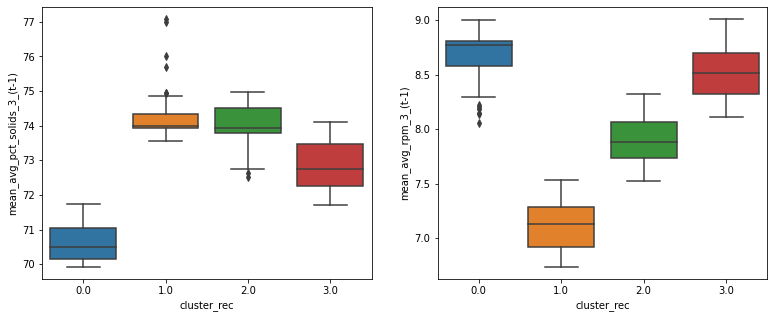

In [27]:
# sns.histplot(data=df_cluster_0, x="mean_avg_rpm_3", hue="cluster_rec") # 'mean_avg_rpm_3','mean_avg_pct_solids_3'
fig, axes = plt.subplots(1,2,figsize=(13,5))
sns.boxplot(data=df20, x="cluster_rec", y='mean_avg_pct_solids_3_(t-1)',ax=axes[0])
sns.boxplot(data=df20, x="cluster_rec", y='mean_avg_rpm_3_(t-1)',ax=axes[1])

# Cluster 1

In [28]:
df_cluster_1=df_mm.copy().query("cluster==1")
df_mm_control1=df_cluster_1[var_operacionales]
inercias = []
K = range(1,15)
for k in K:
    km = KMeans(init='k-means++',n_clusters=k)
    km.fit(df_mm_control1)
    inercias.append(km.inertia_)
    
    y_km=km.predict(df_mm_control1)

fig = px.line( x=K, y=inercias, title="Elbow method") 
fig.show()

In [29]:
# Aplicamos K-means
n_clusters=4
km = KMeans(n_clusters=n_clusters, init='k-means++') 
y_km = km.fit_predict(df_mm_control1) 
df_cluster_1['cluster_rec']=y_km 
df_cluster_1['Atollos_Total_case']=df.loc[df_cluster_1.index,'Atollos_Total_case']
df2.loc[df_cluster_1.index,'cluster_rec']=df_cluster_1['cluster_rec']

df21=df2.copy().query('cluster==1') 

# df21['cluster_rec']=y_km 

df_est=pd.DataFrame() 
Total_atollos=df_cluster_1.Atollos_Total_case.sum()
df_est["Num atollos"]=df_cluster_1[["cluster_rec","Atollos_Total_case"]].groupby("cluster_rec").sum()
df_est["Num casos"]=df_cluster_1[["cluster_rec","Atollos_Total_case"]].groupby("cluster_rec").apply(lambda x: len(x))
df_est["Prob atollo dentro del cluster"]=df_est["Num atollos"]/df_est["Num casos"]*100
df_est["Covertura"]=df_est["Num atollos"]/Total_atollos*100 
df_est["riesgo arcilla"]=df21[["cluster_rec","riesgo_arcilla"]].groupby("cluster_rec").sum()
df_est["Prob riesgo arcilla"]=df_est["riesgo arcilla"]/df_est["Num casos"]*100
 
df_rec_1=df_est.copy()
df_rec_1['pct_cmin']=df21[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.05)['mean_avg_pct_solids_3_(t-1)'] 
df_rec_1['pct_cmax']=df21[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.95)['mean_avg_pct_solids_3_(t-1)']
df_rec_1['pct_med']=df21[["cluster_rec"]+var_operacionales].groupby("cluster_rec").median()['mean_avg_pct_solids_3_(t-1)']
df_rec_1['rpm_cmin']=df21[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.05)['mean_avg_rpm_3_(t-1)']
df_rec_1['rpm_cmax']=df21[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.95)['mean_avg_rpm_3_(t-1)']
df_rec_1['rpm_med']=df21[["cluster_rec"]+var_operacionales].groupby("cluster_rec").median()['mean_avg_rpm_3_(t-1)']
df_rec_1['arc_med']=df21[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()['mean_arcillas_3']
df_rec_1['fino_med']=df21[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()['mean_avg_finos_3_(t-1)']
df_rec_1['tph_med']=df21[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()["mean_avg_fresh_feed_tonnage_3_(t-1)"]
df_rec_1['pebbles_med']=df21[["cluster_rec"]+var_operacionales+var_contexto+["mean_avg_pebbles_3_(t-1)"]].groupby("cluster_rec").median()["mean_avg_pebbles_3_(t-1)"]
df_rec_1['agua_trommel_sag4_med']=df21[["cluster_rec"]+var_operacionales+var_contexto+["mean_agua_trommel_sag4_3_(t-1)"]].groupby("cluster_rec").median()["mean_agua_trommel_sag4_3_(t-1)"]
df_rec_1['agua_harnero_sag4_med']=df21[["cluster_rec"]+var_operacionales+var_contexto+["mean_agua_harnero_sag4_3_(t-1)"]].groupby("cluster_rec").median()["mean_agua_harnero_sag4_3_(t-1)"]
df_rec_1["presion_descanso_med"]=df21[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()["mean_avg_presion_descanso_3_(t-1)"]
df_rec_1['agua_total']=df_rec_1['agua_trommel_sag4_med']+df_rec_1['agua_harnero_sag4_med']
df_rec_1['intermedios_med']=df21[["cluster_rec"]+var_operacionales+var_contexto+["mean_intermedios_3_(t-1)"]].groupby("cluster_rec").median()["mean_intermedios_3_(t-1)"]
df_rec_1 

,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,pct_cmin,pct_cmax,pct_med,rpm_cmin,rpm_cmax,rpm_med,arc_med,fino_med,tph_med,pebbles_med,agua_trommel_sag4_med,agua_harnero_sag4_med,presion_descanso_med,agua_total,intermedios_med
cluster_rec,,,,,,,,,,,,,,,,,,,,,
0,9.0,55,16.363636,15.789474,29,52.727273,74.793135,77.202897,75.392760,7.273983,7.935874,7.648209,0.291356,83.002384,5201.136037,512.116793,77.080788,376.415688,5167.557868,453.496476,11.227707
1,23.0,82,28.048780,40.350877,19,23.170732,72.926268,74.318561,73.781587,7.585019,8.020902,7.825742,0.280308,81.639452,5099.088914,464.324794,63.752660,337.638920,5233.706217,401.391579,11.591287
2,12.0,53,22.641509,21.052632,24,45.283019,72.904268,74.393832,73.901256,6.811659,7.491296,7.309706,0.283519,83.381675,5098.400918,430.368186,43.937674,341.299945,5230.250660,385.237619,9.567162
3,13.0,75,17.333333,22.807018,26,34.666667,72.668219,74.686640,73.812411,8.074993,8.767863,8.253889,0.284035,80.226339,5092.829613,507.390676,87.483179,334.804689,5192.444678,422.287868,12.382559


In [30]:
# promedio de como se comporta cada variable en cada cluster
df_context21=df21[var_contexto+['cluster_rec']].groupby("cluster_rec").mean() 
df_context21

,mean_avg_finos_3_(t-1),mean_recirculated_pebbles_3_(t-1),mean_speed_central_feeders_3_(t-1),mean_avg_fresh_feed_tonnage_3_(t-1),mean_avg_presion_descanso_3_(t-1),mean_arcillas_3,mean_BN_054_3_(t-1),mean_BN_055_3_(t-1)
cluster_rec,,,,,,,,
0.0,83.748410,480.866766,54.323367,5176.186549,5156.749544,0.290897,50.214507,95.900226
1.0,81.351375,470.104373,50.655691,5164.003688,5199.237538,0.278543,62.249870,95.135206
2.0,83.644287,458.249006,45.115770,5106.567052,5201.982996,0.265626,56.975688,88.866351
3.0,79.985596,493.974763,48.971960,5189.070977,5188.912119,0.284453,63.133528,91.512225


In [31]:
# Para las horas de interes se calcula la probabilidad de atollo más cercana
list_prob = []
for i in [0,1,2,3]:
    
    # print(i)
    finos_to_risk = df_context21[df_context21.index
                                    == i]["mean_avg_finos_3_(t-1)"].values[0]
    arcilla_to_risk = df_context21[df_context21.index
                                        == i]["mean_arcillas_3"].values[0]
    df_risk["dist"] = df_risk.apply(lambda x: np.sqrt(
        (x["threshold_arcilla"]-arcilla_to_risk)**2+(x["threshold_finos"]-finos_to_risk)**2), axis=1)
    prob = df_risk[df_risk["dist"] ==
                    df_risk["dist"].min()]["probability"].values[0]
    list_prob.append(prob)
    
# lista de probabilidades
df_rec_1["prob panda"] = list_prob
df_rec_1["prob panda"]=df_rec_1["prob panda"]/max_probability*100
df_rec_1

,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,pct_cmin,pct_cmax,pct_med,rpm_cmin,rpm_cmax,rpm_med,arc_med,fino_med,tph_med,pebbles_med,agua_trommel_sag4_med,agua_harnero_sag4_med,presion_descanso_med,agua_total,intermedios_med,prob panda
cluster_rec,,,,,,,,,,,,,,,,,,,,,,
0,9.0,55,16.363636,15.789474,29,52.727273,74.793135,77.202897,75.392760,7.273983,7.935874,7.648209,0.291356,83.002384,5201.136037,512.116793,77.080788,376.415688,5167.557868,453.496476,11.227707,41.122566
1,23.0,82,28.048780,40.350877,19,23.170732,72.926268,74.318561,73.781587,7.585019,8.020902,7.825742,0.280308,81.639452,5099.088914,464.324794,63.752660,337.638920,5233.706217,401.391579,11.591287,39.747995
2,12.0,53,22.641509,21.052632,24,45.283019,72.904268,74.393832,73.901256,6.811659,7.491296,7.309706,0.283519,83.381675,5098.400918,430.368186,43.937674,341.299945,5230.250660,385.237619,9.567162,39.862543
3,13.0,75,17.333333,22.807018,26,34.666667,72.668219,74.686640,73.812411,8.074993,8.767863,8.253889,0.284035,80.226339,5092.829613,507.390676,87.483179,334.804689,5192.444678,422.287868,12.382559,39.862543


In [32]:
df_rec_1.to_excel("ls1_df_rec_1.xlsx")

<AxesSubplot:xlabel='cluster_rec', ylabel='mean_avg_rpm_3_(t-1)'>

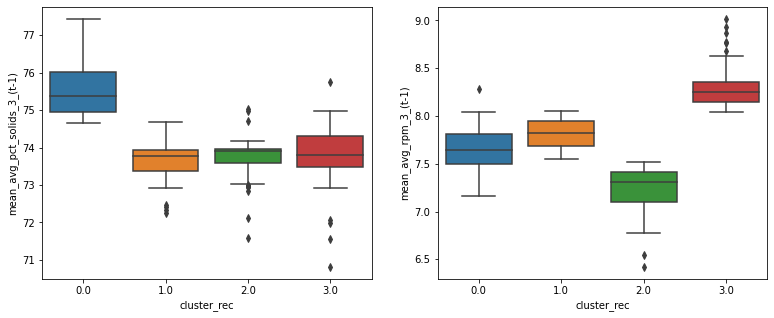

In [33]:
# sns.histplot(data=df_cluster_0, x="mean_avg_rpm_3", hue="cluster_rec") # 'mean_avg_rpm_3','mean_avg_pct_solids_3'
fig, axes = plt.subplots(1,2,figsize=(13,5))
sns.boxplot(data=df21, x="cluster_rec", y='mean_avg_pct_solids_3_(t-1)',ax=axes[0])
sns.boxplot(data=df21, x="cluster_rec", y='mean_avg_rpm_3_(t-1)',ax=axes[1])

# Cluster 2

In [34]:
df_cluster_2=df_mm.copy().query("cluster==2")
df_mm_control2=df_cluster_2[var_operacionales]
inercias = []
K = range(1,15)
for k in K:
    km = KMeans(init='k-means++',n_clusters=k)
    km.fit(df_mm_control2)
    inercias.append(km.inertia_)
    y_km=km.predict(df_mm_control2)
fig = px.line( x=K, y=inercias, title="Elbow method") 
fig.show()

In [35]:
# Aplicamos K-means
n_clusters=4
km = KMeans(n_clusters=n_clusters, init='k-means++') 
y_km = km.fit_predict(df_mm_control2) 
df_cluster_2['cluster_rec']=y_km 
df_cluster_2['Atollos_Total_case']=df.loc[df_cluster_2.index,'Atollos_Total_case']
df2.loc[df_cluster_2.index,'cluster_rec']=df_cluster_2['cluster_rec']

df22=df2.copy().query('cluster==2') 
# df22['cluster_rec']=y_km 

df_est=pd.DataFrame() 
Total_atollos=df_cluster_2.Atollos_Total_case.sum() 
df_est["Num atollos"]=df_cluster_2[["cluster_rec","Atollos_Total_case"]].groupby("cluster_rec").sum() 
df_est["Num casos"]=df_cluster_2[["cluster_rec","Atollos_Total_case"]].groupby("cluster_rec").apply(lambda x: len(x))
df_est["Prob atollo dentro del cluster"]=df_est["Num atollos"]/df_est["Num casos"]*100 
df_est["Covertura"]=df_est["Num atollos"]/Total_atollos*100 
df_est["riesgo arcilla"]=df22[["cluster_rec","riesgo_arcilla"]].groupby("cluster_rec").sum() 
df_est["Prob riesgo arcilla"]=df_est["riesgo arcilla"]/df_est["Num casos"]*100 
 
df_rec_2=df_est.copy()
df_rec_2['pct_cmin']=df22[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.05)['mean_avg_pct_solids_3_(t-1)'] 
df_rec_2['pct_cmax']=df22[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.95)['mean_avg_pct_solids_3_(t-1)']
df_rec_2['pct_med']=df22[["cluster_rec"]+var_operacionales].groupby("cluster_rec").median()['mean_avg_pct_solids_3_(t-1)']
df_rec_2['rpm_cmin']=df22[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.05)['mean_avg_rpm_3_(t-1)']
df_rec_2['rpm_cmax']=df22[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.95)['mean_avg_rpm_3_(t-1)']
df_rec_2['rpm_med']=df22[["cluster_rec"]+var_operacionales].groupby("cluster_rec").median()['mean_avg_rpm_3_(t-1)']
df_rec_2['arc_med']=df22[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()['mean_arcillas_3']
df_rec_2['fino_med']=df22[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()['mean_avg_finos_3_(t-1)']
df_rec_2['tph_med']=df22[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()["mean_avg_fresh_feed_tonnage_3_(t-1)"]
df_rec_2['pebbles_med']=df22[["cluster_rec"]+var_operacionales+var_contexto+["mean_avg_pebbles_3_(t-1)"]].groupby("cluster_rec").median()["mean_avg_pebbles_3_(t-1)"]
df_rec_2['agua_trommel_sag4_med']=df22[["cluster_rec"]+var_operacionales+var_contexto+["mean_agua_trommel_sag4_3_(t-1)"]].groupby("cluster_rec").median()["mean_agua_trommel_sag4_3_(t-1)"]
df_rec_2['agua_harnero_sag4_med']=df22[["cluster_rec"]+var_operacionales+var_contexto+["mean_agua_harnero_sag4_3_(t-1)"]].groupby("cluster_rec").median()["mean_agua_harnero_sag4_3_(t-1)"]
df_rec_2["presion_descanso_med"]=df22[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()["mean_avg_presion_descanso_3_(t-1)"]
df_rec_2['agua_total']=df_rec_2['agua_trommel_sag4_med']+df_rec_2['agua_harnero_sag4_med']
df_rec_2['intermedios_med']=df22[["cluster_rec"]+var_operacionales+var_contexto+["mean_intermedios_3_(t-1)"]].groupby("cluster_rec").median()["mean_intermedios_3_(t-1)"]
df_rec_2


,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,pct_cmin,pct_cmax,pct_med,rpm_cmin,rpm_cmax,rpm_med,arc_med,fino_med,tph_med,pebbles_med,agua_trommel_sag4_med,agua_harnero_sag4_med,presion_descanso_med,agua_total,intermedios_med
cluster_rec,,,,,,,,,,,,,,,,,,,,,
0,80.0,202,39.603960,40.816327,108,53.465347,72.294019,74.150664,73.399876,7.317911,7.862141,7.665628,0.291496,82.815710,5129.737729,399.192457,76.847120,376.028296,5143.012597,452.875417,11.060838
1,57.0,214,26.635514,29.081633,86,40.186916,72.831062,74.340463,73.484408,7.911414,8.418751,8.148421,0.285860,83.173957,5116.841518,345.590300,72.158460,358.804965,5074.890665,430.963424,9.205484
2,36.0,93,38.709677,18.367347,62,66.666667,73.891001,77.221229,74.697677,6.709005,7.746422,7.223892,0.295941,84.471791,5135.594345,447.180936,67.710111,418.569752,5155.237011,486.279863,9.590321
3,23.0,145,15.862069,11.734694,54,37.241379,70.891389,73.295234,72.815732,8.263948,8.873747,8.544004,0.285536,86.218750,5107.389881,291.960472,98.536940,375.532589,5049.684497,474.069529,7.711651


In [36]:
# promedio de como se comporta cada variable en cada cluster
df_context22=df22[var_contexto+['cluster_rec']].groupby("cluster_rec").mean() 
df_context22

,mean_avg_finos_3_(t-1),mean_recirculated_pebbles_3_(t-1),mean_speed_central_feeders_3_(t-1),mean_avg_fresh_feed_tonnage_3_(t-1),mean_avg_presion_descanso_3_(t-1),mean_arcillas_3,mean_BN_054_3_(t-1),mean_BN_055_3_(t-1)
cluster_rec,,,,,,,,
0.0,82.350915,408.511409,44.482872,5162.020760,5126.810205,0.290322,56.566859,39.253571
1.0,83.994986,419.636112,53.252581,5138.711729,5106.203311,0.283826,57.265100,40.071539
2.0,84.002829,419.544697,41.286803,5167.236557,5179.766596,0.295917,55.561893,37.440063
3.0,85.847935,384.920510,56.748008,5125.700494,5087.272203,0.285069,51.592637,40.725335


In [37]:
# Para las horas de interes se calcula la probabilidad de atollo más cercana
list_prob = []
for i in [0,1,2,3]:
    
    # print(i)
    finos_to_risk = df_context22[df_context22.index
                                    == i]["mean_avg_finos_3_(t-1)"].values[0]
    arcilla_to_risk = df_context22[df_context22.index
                                        == i]["mean_arcillas_3"].values[0]
    df_risk["dist"] = df_risk.apply(lambda x: np.sqrt(
        (x["threshold_arcilla"]-arcilla_to_risk)**2+(x["threshold_finos"]-finos_to_risk)**2), axis=1)
    prob = df_risk[df_risk["dist"] ==
                    df_risk["dist"].min()]["probability"].values[0]
    list_prob.append(prob)
    
# lista de probabilidades
df_rec_2["prob panda"] = list_prob
df_rec_2["prob panda"]=df_rec_2["prob panda"]/max_probability*100
df_rec_2

,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,pct_cmin,pct_cmax,pct_med,rpm_cmin,rpm_cmax,rpm_med,arc_med,fino_med,tph_med,pebbles_med,agua_trommel_sag4_med,agua_harnero_sag4_med,presion_descanso_med,agua_total,intermedios_med,prob panda
cluster_rec,,,,,,,,,,,,,,,,,,,,,,
0,80.0,202,39.603960,40.816327,108,53.465347,72.294019,74.150664,73.399876,7.317911,7.862141,7.665628,0.291496,82.815710,5129.737729,399.192457,76.847120,376.028296,5143.012597,452.875417,11.060838,41.122566
1,57.0,214,26.635514,29.081633,86,40.186916,72.831062,74.340463,73.484408,7.911414,8.418751,8.148421,0.285860,83.173957,5116.841518,345.590300,72.158460,358.804965,5074.890665,430.963424,9.205484,39.518900
2,36.0,93,38.709677,18.367347,62,66.666667,73.891001,77.221229,74.697677,6.709005,7.746422,7.223892,0.295941,84.471791,5135.594345,447.180936,67.710111,418.569752,5155.237011,486.279863,9.590321,40.206186
3,23.0,145,15.862069,11.734694,54,37.241379,70.891389,73.295234,72.815732,8.263948,8.873747,8.544004,0.285536,86.218750,5107.389881,291.960472,98.536940,375.532589,5049.684497,474.069529,7.711651,41.122566


In [38]:
df_rec_2.to_excel("ls1_df_rec_2.xlsx")

<AxesSubplot:xlabel='cluster_rec', ylabel='mean_avg_rpm_3_(t-1)'>

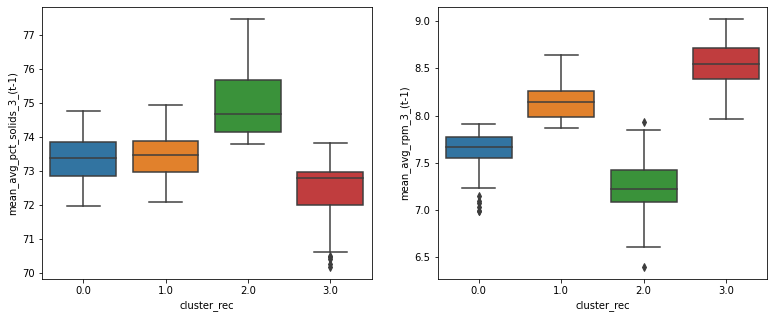

In [39]:
# sns.histplot(data=df_cluster_0, x="mean_avg_rpm_3", hue="cluster_rec") # 'mean_avg_rpm_3','mean_avg_pct_solids_3'
fig, axes = plt.subplots(1,2,figsize=(13,5))
sns.boxplot(data=df22, x="cluster_rec", y='mean_avg_pct_solids_3_(t-1)',ax=axes[0])
sns.boxplot(data=df22, x="cluster_rec", y='mean_avg_rpm_3_(t-1)',ax=axes[1])

# Cluster 3

In [40]:
df_cluster_3=df_mm.copy().query("cluster==3") 
df_mm_control3=df_cluster_3[var_operacionales] 
inercias = [] 
K = range(1,15) 
for k in K: 
    km = KMeans(init='k-means++',n_clusters=k) 
    km.fit(df_mm_control3) 
    inercias.append(km.inertia_) 
    y_km=km.predict(df_mm_control3) 
fig = px.line( x=K, y=inercias, title="Elbow method") 
fig.show() 

In [41]:
# Aplicamos K-means
n_clusters=4
km = KMeans(n_clusters=n_clusters, init='k-means++') 
y_km = km.fit_predict(df_mm_control3) 
df_cluster_3['cluster_rec']=y_km 
df_cluster_3['Atollos_Total_case']=df.loc[df_cluster_3.index,'Atollos_Total_case']
df2.loc[df_cluster_3.index,'cluster_rec']=df_cluster_3['cluster_rec']

df23=df2.copy().query('cluster==3') 
# df23['cluster_rec']=y_km 

df_est=pd.DataFrame() 
Total_atollos=df_cluster_3.Atollos_Total_case.sum()
df_est["Num atollos"]=df_cluster_3[["cluster_rec","Atollos_Total_case"]].groupby("cluster_rec").sum()
df_est["Num casos"]=df_cluster_3[["cluster_rec","Atollos_Total_case"]].groupby("cluster_rec").apply(lambda x: len(x))
df_est["Prob atollo dentro del cluster"]=df_est["Num atollos"]/df_est["Num casos"]*100
df_est["Covertura"]=df_est["Num atollos"]/Total_atollos*100 
df_est["riesgo arcilla"]=df23[["cluster_rec","riesgo_arcilla"]].groupby("cluster_rec").sum()
df_est["Prob riesgo arcilla"]=df_est["riesgo arcilla"]/df_est["Num casos"]*100
 
df_rec_3=df_est.copy()
df_rec_3['pct_cmin']=df23[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.05)['mean_avg_pct_solids_3_(t-1)'] 
df_rec_3['pct_cmax']=df23[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.95)['mean_avg_pct_solids_3_(t-1)']
df_rec_3['pct_med']=df23[["cluster_rec"]+var_operacionales].groupby("cluster_rec").median()['mean_avg_pct_solids_3_(t-1)']
df_rec_3['rpm_cmin']=df23[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.05)['mean_avg_rpm_3_(t-1)']
df_rec_3['rpm_cmax']=df23[["cluster_rec"]+var_operacionales].groupby("cluster_rec").quantile(q=0.95)['mean_avg_rpm_3_(t-1)']
df_rec_3['rpm_med']=df23[["cluster_rec"]+var_operacionales].groupby("cluster_rec").median()['mean_avg_rpm_3_(t-1)']
df_rec_3['arc_med']=df23[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()['mean_arcillas_3'] 
df_rec_3['fino_med']=df23[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()['mean_avg_finos_3_(t-1)']
df_rec_3['tph_med']=df23[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()["mean_avg_fresh_feed_tonnage_3_(t-1)"]
df_rec_3['pebbles_med']=df23[["cluster_rec"]+var_operacionales+var_contexto+["mean_avg_pebbles_3_(t-1)"]].groupby("cluster_rec").median()["mean_avg_pebbles_3_(t-1)"]
df_rec_3['agua_trommel_sag4_med']=df23[["cluster_rec"]+var_operacionales+var_contexto+["mean_agua_trommel_sag4_3_(t-1)"]].groupby("cluster_rec").median()["mean_agua_trommel_sag4_3_(t-1)"]
df_rec_3['agua_harnero_sag4_med']=df23[["cluster_rec"]+var_operacionales+var_contexto+["mean_agua_harnero_sag4_3_(t-1)"]].groupby("cluster_rec").median()["mean_agua_harnero_sag4_3_(t-1)"]
df_rec_3["presion_descanso_med"]=df23[["cluster_rec"]+var_operacionales+var_contexto].groupby("cluster_rec").median()["mean_avg_presion_descanso_3_(t-1)"]
df_rec_3['agua_total']=df_rec_3['agua_trommel_sag4_med']+df_rec_3['agua_harnero_sag4_med']
df_rec_3['intermedios_med']=df23[["cluster_rec"]+var_operacionales+var_contexto+["mean_intermedios_3_(t-1)"]].groupby("cluster_rec").median()["mean_intermedios_3_(t-1)"]
df_rec_3 

,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,pct_cmin,pct_cmax,pct_med,rpm_cmin,rpm_cmax,rpm_med,arc_med,fino_med,tph_med,pebbles_med,agua_trommel_sag4_med,agua_harnero_sag4_med,presion_descanso_med,agua_total,intermedios_med
cluster_rec,,,,,,,,,,,,,,,,,,,,,
0,22.0,64,34.375000,23.655914,38,59.375000,72.791216,74.099802,73.845514,6.870609,7.851573,7.567398,0.291690,83.224763,5199.134518,414.599591,34.969555,360.501524,5243.799060,395.471079,8.546242
1,31.0,103,30.097087,33.333333,61,59.223301,72.910984,74.832650,73.848989,7.909886,8.661471,8.258402,0.292699,81.385643,5235.165055,378.252441,73.571024,305.086716,5235.265270,378.657740,9.652473
2,6.0,41,14.634146,6.451613,7,17.073171,70.913076,73.248549,72.509702,8.261856,8.984600,8.696588,0.279431,82.611719,5173.822622,402.122067,73.895913,318.392071,5230.133917,392.287984,8.906202
3,34.0,54,62.962963,36.559140,26,48.148148,75.193087,76.906838,76.004483,7.797365,8.665234,8.255032,0.289167,79.817951,5361.771143,435.877984,52.326812,322.254423,5179.295181,374.581234,12.796853


In [42]:
# promedio de como se comporta cada variable en cada cluster
df_context23=df23[var_contexto+['cluster_rec']].groupby("cluster_rec").mean() 
df_context23

,mean_avg_finos_3_(t-1),mean_recirculated_pebbles_3_(t-1),mean_speed_central_feeders_3_(t-1),mean_avg_fresh_feed_tonnage_3_(t-1),mean_avg_presion_descanso_3_(t-1),mean_arcillas_3,mean_BN_054_3_(t-1),mean_BN_055_3_(t-1)
cluster_rec,,,,,,,,
0.0,80.928709,417.746350,86.992747,5204.035429,5237.140347,0.290680,53.339654,39.375155
1.0,79.977212,383.078435,93.303764,5262.956294,5215.522732,0.290586,53.997907,49.330589
2.0,78.519352,327.954400,89.189408,5201.381139,5206.989047,0.273397,50.561290,47.359489
3.0,80.520585,374.102630,95.992848,5348.648544,5181.297961,0.289150,71.046060,58.410807


In [43]:
# Para las horas de interes se calcula la probabilidad de atollo más cercana
list_prob = []
for i in [0,1,2,3]:
    
    # print(i)
    finos_to_risk = df_context23[df_context23.index
                                    == i]["mean_avg_finos_3_(t-1)"].values[0]
    arcilla_to_risk = df_context23[df_context23.index
                                        == i]["mean_arcillas_3"].values[0]
    df_risk["dist"] = df_risk.apply(lambda x: np.sqrt(
        (x["threshold_arcilla"]-arcilla_to_risk)**2+(x["threshold_finos"]-finos_to_risk)**2), axis=1)
    prob = df_risk[df_risk["dist"] ==
                    df_risk["dist"].min()]["probability"].values[0]
    list_prob.append(prob)
    
# lista de probabilidades
df_rec_3["prob panda"] = list_prob
df_rec_3["prob panda"]=df_rec_3["prob panda"]/max_probability*100
df_rec_3

,Num atollos,Num casos,Prob atollo dentro del cluster,Covertura,riesgo arcilla,Prob riesgo arcilla,pct_cmin,pct_cmax,pct_med,rpm_cmin,rpm_cmax,rpm_med,arc_med,fino_med,tph_med,pebbles_med,agua_trommel_sag4_med,agua_harnero_sag4_med,presion_descanso_med,agua_total,intermedios_med,prob panda
cluster_rec,,,,,,,,,,,,,,,,,,,,,,
0,22.0,64,34.375000,23.655914,38,59.375000,72.791216,74.099802,73.845514,6.870609,7.851573,7.567398,0.291690,83.224763,5199.134518,414.599591,34.969555,360.501524,5243.799060,395.471079,8.546242,41.237113
1,31.0,103,30.097087,33.333333,61,59.223301,72.910984,74.832650,73.848989,7.909886,8.661471,8.258402,0.292699,81.385643,5235.165055,378.252441,73.571024,305.086716,5235.265270,378.657740,9.652473,41.237113
2,6.0,41,14.634146,6.451613,7,17.073171,70.913076,73.248549,72.509702,8.261856,8.984600,8.696588,0.279431,82.611719,5173.822622,402.122067,73.895913,318.392071,5230.133917,392.287984,8.906202,40.549828
3,34.0,54,62.962963,36.559140,26,48.148148,75.193087,76.906838,76.004483,7.797365,8.665234,8.255032,0.289167,79.817951,5361.771143,435.877984,52.326812,322.254423,5179.295181,374.581234,12.796853,41.237113


In [44]:
df_rec_3.to_excel("ls1_df_rec_3.xlsx")

<AxesSubplot:xlabel='cluster_rec', ylabel='mean_avg_rpm_3_(t-1)'>

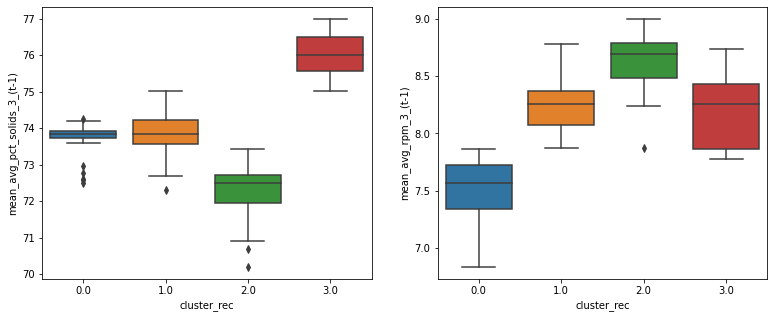

In [45]:
# sns.histplot(data=df_cluster_0, x="mean_avg_rpm_3", hue="cluster_rec") # 'mean_avg_rpm_3','mean_avg_pct_solids_3'
fig, axes = plt.subplots(1,2,figsize=(13,5)) 
sns.boxplot(data=df23, x="cluster_rec", y='mean_avg_pct_solids_3_(t-1)',ax=axes[0]) 
sns.boxplot(data=df23, x="cluster_rec", y='mean_avg_rpm_3_(t-1)',ax=axes[1]) 